In [130]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

In [131]:
net = cv.dnn.readNetFromTensorflow(r"C:\Users\JAYESH AHIRE\open-pose\graph_opt.pb")

In [132]:
inWidth = 368
inHeight = 368
thr = 0.1

In [133]:
# Body parts and pose pairs definitions
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

In [134]:
def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    # Set input blob for the network
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]
    
    assert(len(BODY_PARTS) == out.shape[1])
    
    points = [None] * len(BODY_PARTS)
    
    for i in range(len(BODY_PARTS)):
        heatMap = out[0, i, :, :]
        
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = int(frameWidth * point[0] / out.shape[3])
        y = int(frameHeight * point[1] / out.shape[2])
        if conf > thr:
            points[i] = (x, y)
    
    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            pt1 = tuple(map(int, points[idFrom]))
            pt2 = tuple(map(int, points[idTo]))
            
            # Draw line and ellipses
            cv.line(frame, pt1, pt2, (0, 255, 0), 3)
            cv.ellipse(frame, pt1, (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, pt2, (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    # Display performance information
    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    
    return frame

In [135]:

# Define paths to YOLOv4 configuration and weights
yolo_config = r"C:\Users\JAYESH AHIRE\open-pose\yolov4.cfg"
yolo_weights = r"C:\Users\JAYESH AHIRE\open-pose\yolov4.weights"
yolo_classes = r"C:\Users\JAYESH AHIRE\open-pose\coco.names" # COCO dataset classes for YOLO

# Load YOLOv4 model
net_detector = cv.dnn.readNetFromDarknet(yolo_config, yolo_weights)

# Load classes for YOLOv4 (COCO dataset)
classes = []
with open(yolo_classes, "r") as f:
    classes = [line.strip() for line in f.readlines()]

# Function to find main object using YOLOv4
def find_main_object(image_path):
    try:
        img = cv.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Image '{image_path}' not found or could not be loaded.")
        
        height, width, _ = img.shape
        
        # Get the names of the output layers
        layer_names = net_detector.getLayerNames()
        output_layers = [layer_names[i - 1] for i in net_detector.getUnconnectedOutLayers()]
        
        # Prepare the image as a blob for the neural network
        blob = cv.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
        net_detector.setInput(blob)
        
        # Forward pass to get the detections
        outs = net_detector.forward(output_layers)
        
        # Initialize lists for detections
        class_ids = []
        confidences = []
        boxes = []
        
        # Process each layer's output
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                
                # Check if the detected object is a person (class_id 0 corresponds to 'person' in COCO dataset)
                if class_id == 0 and confidence >= 0.5:  # Adjust confidence threshold as needed
                    # Scale the bounding box coordinates relative to the size of the image
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    
                    # Calculate the top-left corner of the bounding box
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)
                    
                    # Store the bounding box coordinates, class_id, and confidence
                    boxes.append([x, y, w, h])
                    confidences.append(float(confidence))
                    class_ids.append(class_id)
        
        # Check if any 'person' detections were found
        if not boxes:
            raise ValueError("No 'person' detected in the image with sufficient confidence.")
        
        # Get the index of the highest confidence 'person' detection
        main_object_index = np.argmax(confidences)
        x, y, w, h = boxes[main_object_index]
        
        # Crop the main object (person) from the image
        main_object_image = img[y:y+h, x:x+w]
        
        return main_object_image
    
    except Exception as e:
        print(f"Error in processing image '{image_path}': {str(e)}")
        return None

In [136]:
main_object_image = find_main_object(r"C:\Users\JAYESH AHIRE\open-pose\6a9erc.jpg")
pose_estimated_image = pose_estimation(main_object_image.copy())

main_object_image1 = find_main_object(r"C:\Users\JAYESH AHIRE\open-pose\0e9091993fc0289656646088f0ea93f7.jpg")
pose_estimated_image1 = pose_estimation(main_object_image1.copy())

main_object_image2 = find_main_object(r"C:\Users\JAYESH AHIRE\open-pose\3vtsmc.jpg")
pose_estimated_image2 = pose_estimation(main_object_image2.copy())

main_object_image3 = find_main_object(r"C:\Users\JAYESH AHIRE\open-pose\6d755c5d3f8331bd85f055cf60b803d4.jpg")
pose_estimated_image3 = pose_estimation(main_object_image3.copy())

main_object_image4 = find_main_object(r"C:\Users\JAYESH AHIRE\open-pose\IIT-Kanpur-professor-decodes-Jasprit-Bumrahs-unconventional-bowling-action.jpg")
pose_estimated_image4 = pose_estimation(main_object_image4.copy())


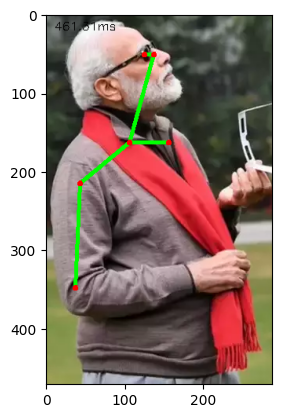

In [137]:
plt.imshow(cv.cvtColor(pose_estimated_image, cv.COLOR_BGR2RGB))

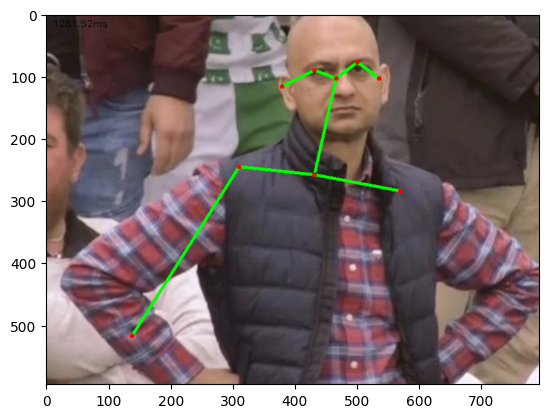

In [138]:
plt.imshow(cv.cvtColor(pose_estimated_image1, cv.COLOR_BGR2RGB))

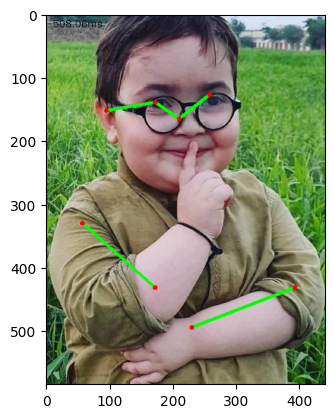

In [139]:
plt.imshow(cv.cvtColor(pose_estimated_image2, cv.COLOR_BGR2RGB))

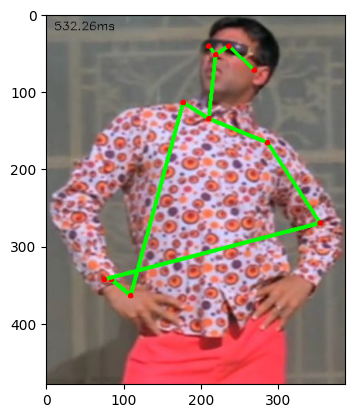

In [140]:
plt.imshow(cv.cvtColor(pose_estimated_image3, cv.COLOR_BGR2RGB))

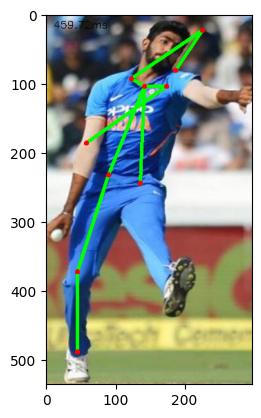

In [141]:
plt.imshow(cv.cvtColor(pose_estimated_image4, cv.COLOR_BGR2RGB))